In [22]:
# import Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore') #ignore warning messages

In [23]:
# Read data
data = pd.read_csv("dataR2.csv")

In [24]:
# Drop useless variables
data = data.drop(['Age','BMI'],axis = 1)

# Reassign target
#data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

In [25]:
# View first 5 data
data.head()

,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,diagnosis
0,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,0
1,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,0
2,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,0
3,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,0
4,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,0


In [26]:
# describe data
data.describe()

,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,diagnosis
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000,0.551724
std,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663,0.499475
min,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000,0.000000
25%,85.750000,4.359250,0.917966,12.313675,5.474282,6.881763,269.978250,0.000000
50%,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500,1.000000
75%,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000,1.000000
max,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,1.000000


In [27]:
# divide the first column into 2 datasets
M = data[(data['diagnosis'] != 0)]
B = data[(data['diagnosis'] == 0)]

In [28]:
# plot of count data
trace = go.Bar(x = (len(M), len(B)), y = ['presence', 'absence'], orientation = 'h', opacity = 0.8, marker=dict(
        color=[ 'red', 'blue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of diagnosis variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

# plot percentage of data
trace = go.Pie(labels = ['presence','absence'], values = data['diagnosis'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['blue', 'red'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of diagnosis variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [33]:
#identify distribution plot
def plot_distribution(data_select, size_bin) :  
    tmp1 = M[data_select]
    tmp2 = B[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['presence', 'absence']
    colors = ['#FF0000', '#0000FF']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [34]:
#plot distribution 'mean'
plot_distribution('Glucose', 5)
plot_distribution('Insulin', 1)
plot_distribution('HOMA', .5)
plot_distribution('Leptin', 1)
plot_distribution('Adiponectin', 1)
plot_distribution('Resistin', 1)
plot_distribution('MCP.1', 100)

In [31]:
#define correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

In [32]:
#plot correlation matrix
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   xgap = 2,
                   ygap = 2,
                   colorscale='Magma',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

In [35]:
#compare correlation between 2 features
def plot_feat1_feat2(feat1, feat2) :  
    trace0 = go.Scatter(
        x = M[feat1],
        y = M[feat2],
        name = 'presence',
        mode = 'markers', 
        marker = dict(color = '#FF0000',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = B[feat1],
        y = B[feat2],
        name = 'absence',
        mode = 'markers',
        marker = dict(color = '#0000FF',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

In [38]:
#4 samples of positive correlated features
plot_feat1_feat2('Insulin','HOMA')
plot_feat1_feat2('Insulin','Glucose')
plot_feat1_feat2('Leptin','Glucose')
plot_feat1_feat2('HOMA','Leptin')

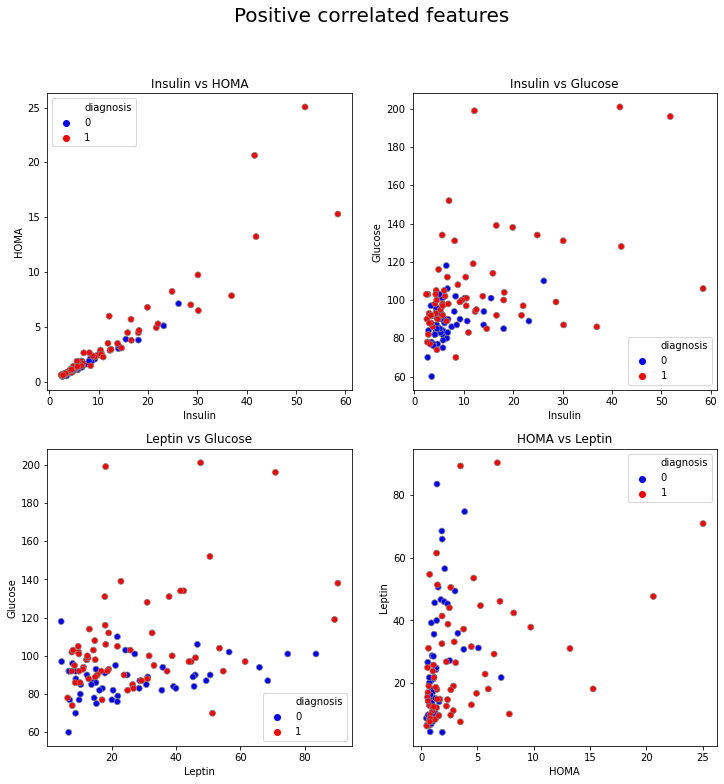

In [39]:
#seaborn version : 

palette ={0 : 'blue', 1 : 'red'}
edgecolor = 'grey'

# Plot +
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['Insulin'], y = data['HOMA'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor=edgecolor)
plt.title('Insulin vs HOMA')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['Insulin'], y = data['Glucose'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('Insulin vs Glucose')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['Leptin'], y = data['Glucose'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('Leptin vs Glucose')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['HOMA'], y = data['Leptin'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('HOMA vs Leptin')

fig.suptitle('Positive correlated features', fontsize = 20)
plt.savefig('1')
plt.show()

In [42]:
#4 samples of uncorrelated features

plot_feat1_feat2('Insulin','MCP.1')
plot_feat1_feat2('MCP.1','Leptin')
plot_feat1_feat2('HOMA','Adiponectin')
plot_feat1_feat2('Insulin','Adiponectin')

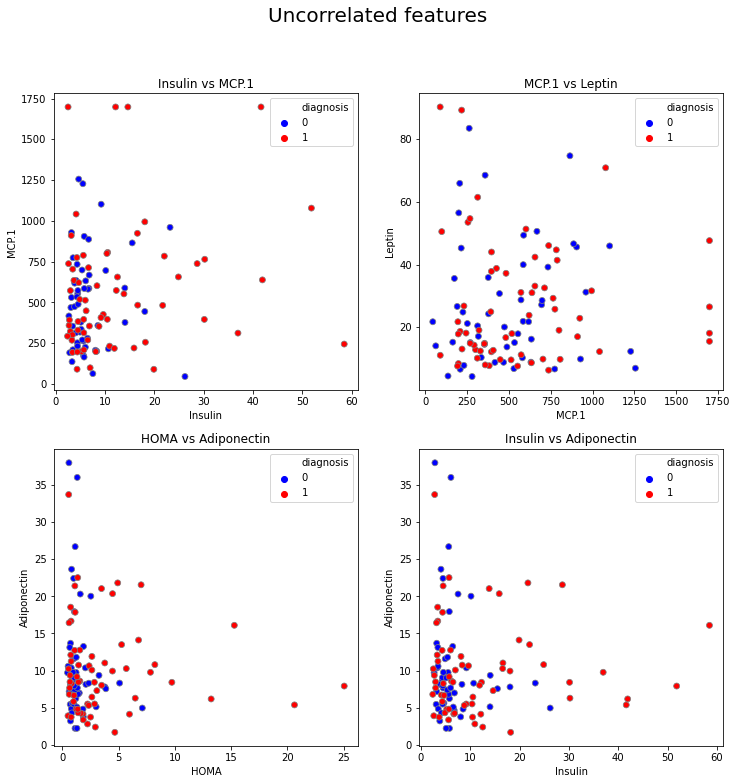

In [43]:
# seaborn version : 

fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['Insulin'], y = data['MCP.1'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('Insulin vs MCP.1')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['MCP.1'], y = data['Leptin'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('MCP.1 vs Leptin')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['HOMA'], y = data['Adiponectin'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('HOMA vs Adiponectin')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['Insulin'], y = data['Adiponectin'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('Insulin vs Adiponectin')

fig.suptitle('Uncorrelated features', fontsize = 20)
plt.savefig('2')
plt.show()

In [45]:
#4 samples of negative correlated features

plot_feat1_feat2('Resistin','Adiponectin')
plot_feat1_feat2('MCP.1','Adiponectin')
plot_feat1_feat2('Glucose','Adiponectin')
plot_feat1_feat2('Leptin','Adiponectin')

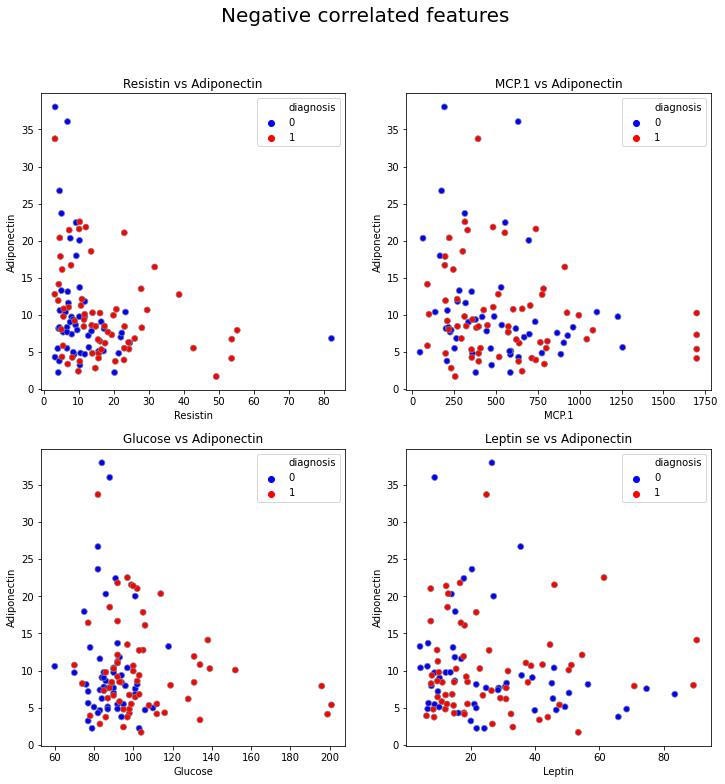

In [46]:
# seaborn version

fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['Resistin'], y = data['Adiponectin'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('Resistin vs Adiponectin')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['MCP.1'], y = data['Adiponectin'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('MCP.1 vs Adiponectin')
plt.subplot(223)
ax2 = sns.scatterplot(x = data['Glucose'], y = data['Adiponectin'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('Glucose vs Adiponectin')
plt.subplot(224)
ax2 = sns.scatterplot(x = data['Leptin'], y = data['Adiponectin'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('Leptin se vs Adiponectin')

fig.suptitle('Negative correlated features', fontsize = 20)
plt.savefig('3')
plt.show()

In [47]:
# Define Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Reds) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

In [48]:
# Define Precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

In [49]:
# Define ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'r--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

In [50]:
#Define Learning curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "b",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

In [51]:
# Define cross-validation metrics
def cross_val_metrics(model) :
    scores = ['f1','accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [52]:
#Prepare dataset
# Define X(features) and Y(diagnosis(M or B))
y = np.array(data.diagnosis.tolist())
data1 = data.drop('diagnosis', 1)
X = np.array(data1.values)

In [53]:
# Data standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [54]:
# Split data to train and test set
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

In [55]:
#Logistic Regression
# Find best hyperparameters by logistic regression and GridSearchCV (accuracy)
log_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


The best parameters for using this model is {'C': 10, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.1s finished


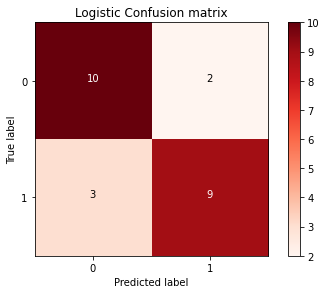

Accuracy  =     0.792
Precision =     0.818
Recall    =     0.750
F1_score  =     0.783


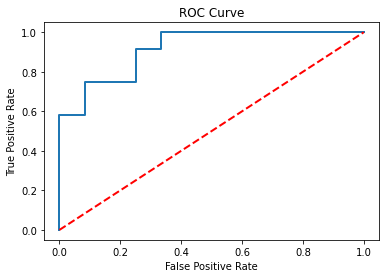

In [56]:
#Logistic Regression with best hyperparameters
CV_log_clf = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf.fit(X_train, y_train)
y_pred = CV_log_clf.predict(X_test)
y_score = CV_log_clf.decision_function(X_test)

# Confusion maxtrix & metrics, plot the matrix and show its value
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve, plot ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

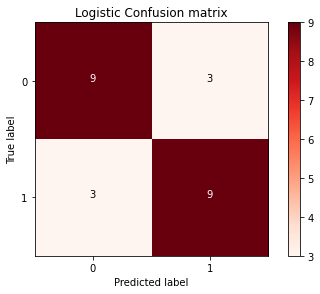

Accuracy  =     0.750
Precision =     0.750
Recall    =     0.750
F1_score  =     0.750


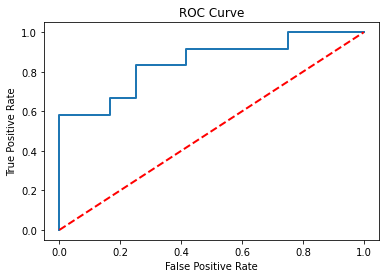

In [57]:
#Logistic regression with Recursive Feature Elimination (RFE), apply RFE to eliminate from 30 to 15 features
log_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)

selector = RFE(log_clf)
selector = selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)
y_score = selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics, plot the matrix and show its value
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.show()

show_metrics()

# ROC curve, plot ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

In [58]:
# support and ranking of RFE
print(selector.support_)
print(selector.ranking_)

[ True  True False  True False False False]
[1 1 4 1 3 2 5]


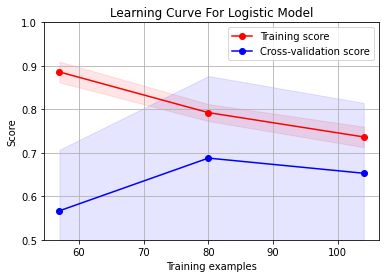

In [59]:
#Learning curve of Logistic Regression with best hyperparameter
plot_learning_curve(CV_log_clf, 'Learning Curve For Logistic Model', X, y, (0.5,1), 10)
plt.savefig('7')
plt.show()

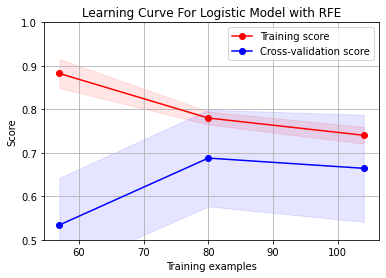

In [60]:
#Learning curve of Logistic Regression with RFE
plot_learning_curve(selector, 'Learning Curve For Logistic Model with RFE', X, y, (0.5,1), 10)
plt.show()

In [61]:
# Cross-validation metrics of Logistic Regression 
cross_log = cross_val_metrics(CV_log_clf)

[f1] : 0.71983 (+/- 0.16664)
[accuracy] : 0.70725 (+/- 0.12615)
[precision] : 0.71514 (+/- 0.09289)
[recall] : 0.75128 (+/- 0.23439)


In [62]:
# Cross-validation metrics of Logistic Regression with RFE
cross_selector = cross_val_metrics(selector)

[f1] : 0.74697 (+/- 0.08973)
[accuracy] : 0.71558 (+/- 0.08483)
[precision] : 0.72489 (+/- 0.06628)
[recall] : 0.78077 (+/- 0.13301)


Recall w/ threshold = 0.08 : 1.0
Recall w/ threshold = 0.1 : 1.0
Recall w/ threshold = 0.2 : 1.0
Recall w/ threshold = 0.3 : 1.0
Recall w/ threshold = 0.4 : 0.8333333333333334
Recall w/ threshold = 0.5 : 0.75


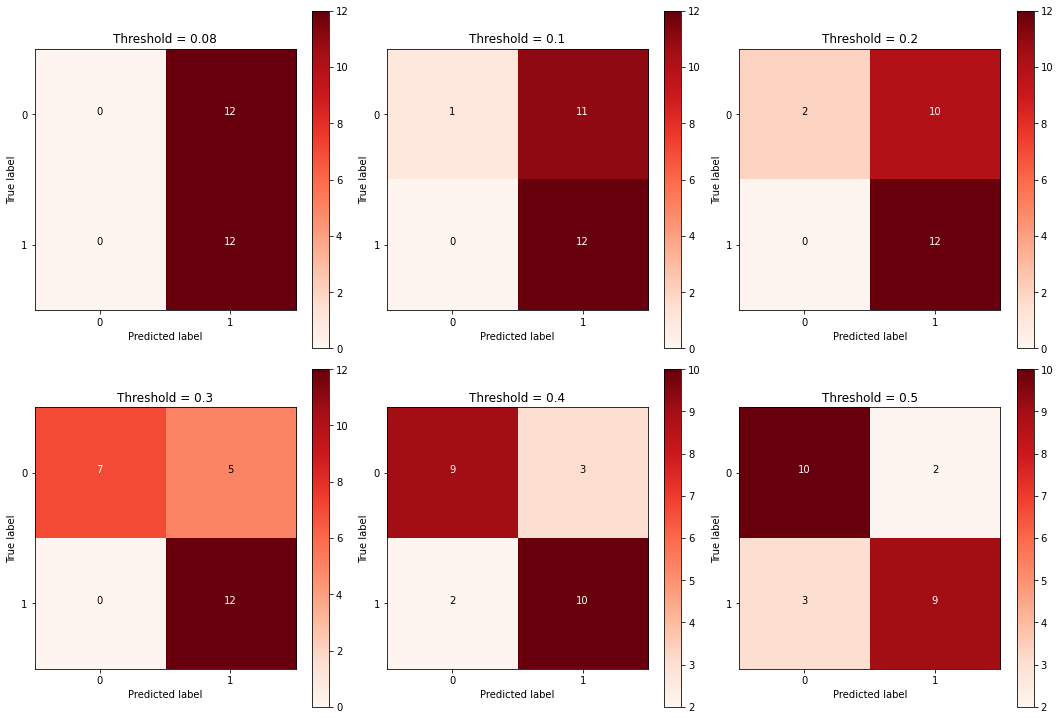

In [63]:
# Select threshold for 100% recall
thresholds_adj = [0.08,0.1,0.2,0.3,0.4,0.5]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = CV_log_clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 

In [64]:
# Prediction with recall = 100%
y_score = CV_log_clf.predict_proba(X_test)[:,1] > 0.3
cm = confusion_matrix(y_test, y_score)
class_names = [0,1]
show_metrics()

Accuracy  =     0.792
Precision =     0.706
Recall    =     1.000
F1_score  =     0.828


In [65]:
#Ensemble classifier
#Logistic Regression 
# Find the best hyperparameters (recall)
log2_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            }

CV_log2_clf = GridSearchCV(estimator = log2_clf, param_grid = param_grid , scoring = 'recall', verbose = 1, n_jobs = -1)
CV_log2_clf.fit(X_train, y_train)

best_parameters = CV_log2_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
The best parameters for using this model is {'C': 0.001, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  47 out of  70 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.0s finished


In [66]:
# Logistic Regression with best hyperparameters (recall)
CV_log2_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)


CV_log2_clf.fit(X_train, y_train)

y_pred = CV_log2_clf.predict(X_test)
y_score = CV_log2_clf.decision_function(X_test)
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

In [67]:
# Cross-validation metrics of logistic regression ensemble classifier
cross_val_metrics(CV_log2_clf)

[f1] : 0.71102 (+/- 0.01474)
[accuracy] : 0.55181 (+/- 0.01759)
[precision] : 0.55181 (+/- 0.01759)
[recall] : 1.00000 (+/- 0.00000)


In [68]:
#Voting Classifier
voting_clf = VotingClassifier (
        estimators = [('log1', CV_log_clf), ('log_2', CV_log2_clf)],
                     voting='soft', weights = [1, 1])
    
voting_clf.fit(X_train,y_train)

y_pred = voting_clf.predict(X_test)
y_score = voting_clf.predict_proba(X_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
show_metrics()

Accuracy  =     0.792
Precision =     0.818
Recall    =     0.750
F1_score  =     0.783


In [69]:
# Cross-validation metrics of voting classifier
cross_voting = cross_val_metrics(voting_clf)

[f1] : 0.72028 (+/- 0.16961)
[accuracy] : 0.69855 (+/- 0.12813)
[precision] : 0.69339 (+/- 0.09222)
[recall] : 0.78333 (+/- 0.24927)


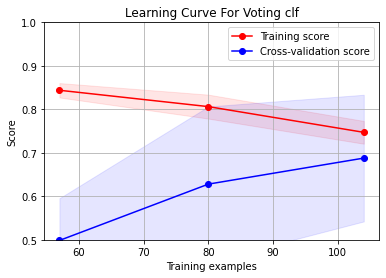

In [70]:
#Learning curve of Voting classifier
plot_learning_curve(voting_clf, 'Learning Curve For Voting clf', X, y, (0.5,1), 10)
plt.savefig('9')
plt.show()

Recall w/ threshold = 0.05 : 1.0
Recall w/ threshold = 0.1 : 1.0
Recall w/ threshold = 0.2 : 1.0
Recall w/ threshold = 0.3 : 1.0
Recall w/ threshold = 0.4 : 1.0
Recall w/ threshold = 0.5 : 0.75
Recall w/ threshold = 0.6 : 0.5
Recall w/ threshold = 0.7 : 0.4166666666666667
Recall w/ threshold = 0.8 : 0.0


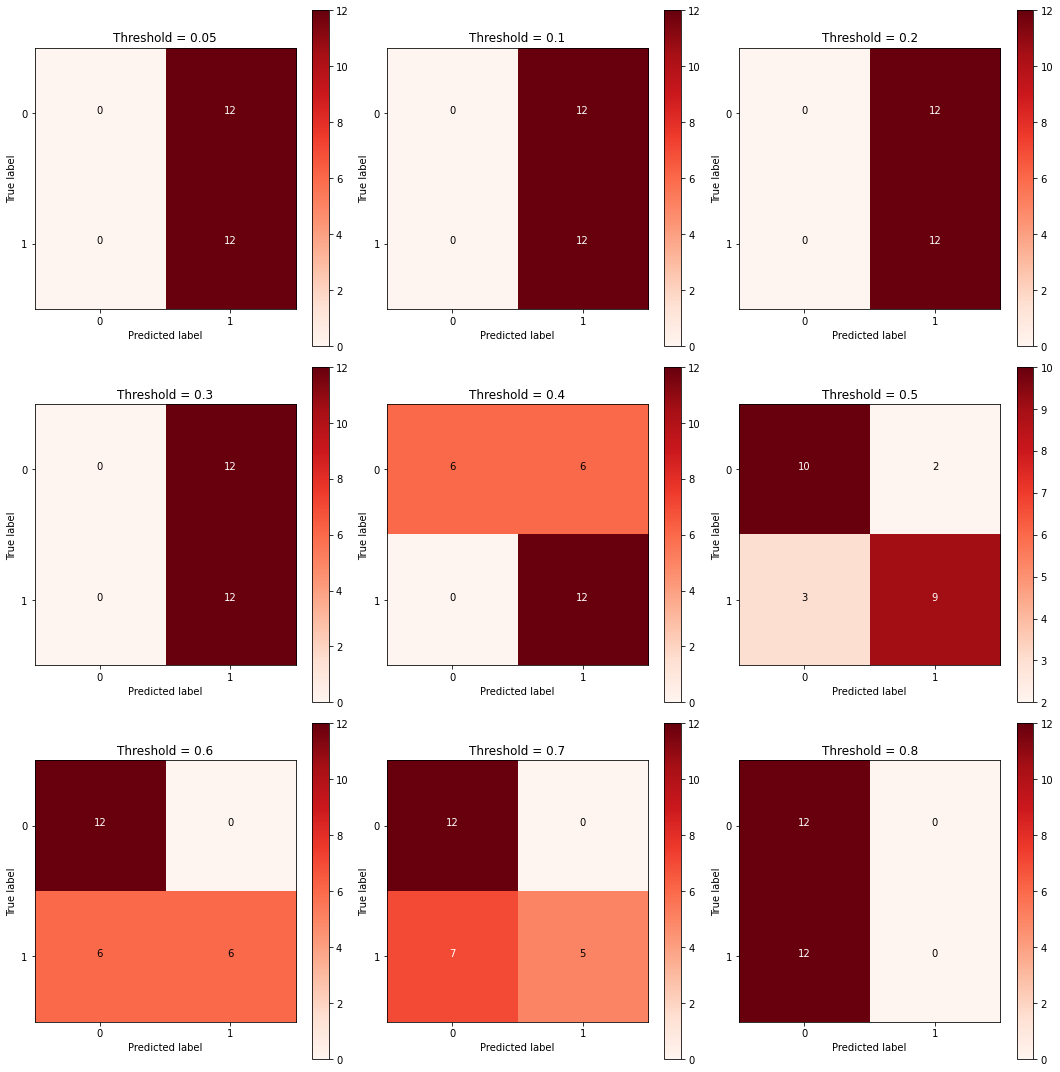

In [71]:
# Select Threshold with recall = 100%
thresholds_adj = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = voting_clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i)

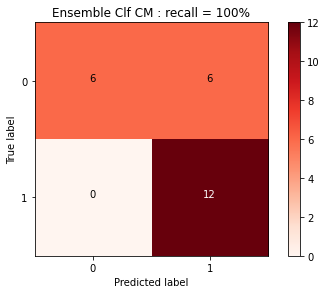

Accuracy  =     0.750
Precision =     0.667
Recall    =     1.000
F1_score  =     0.800


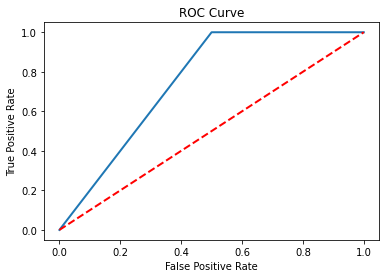

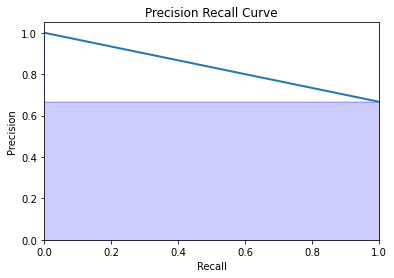

In [72]:
# Voting classifier with recall = 100%
y_score = voting_clf.predict_proba(X_test)[:,1] > 0.4
cm = confusion_matrix(y_test, y_score)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'Ensemble Clf CM : recall = 100%')
plt.savefig('8')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

In [73]:
#Support Vector Machine (SVM)
#Define variables
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
#Define output results
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [75]:
#Linear Kernel SVM
from sklearn.svm import LinearSVC

linear_kernel_SVM = LinearSVC(loss='hinge', dual=True)
linear_kernel_SVM.fit(X_train, y_train)

print_score(linear_kernel_SVM, X_train, y_train, X_test, y_test, train=True)
print_score(linear_kernel_SVM, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 75.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.688889   0.808511      0.75   0.748700      0.756501
recall      0.775000   0.730769      0.75   0.752885      0.750000
f1-score    0.729412   0.767677      0.75   0.748544      0.751040
support    40.000000  52.000000      0.75  92.000000     92.000000
_______________________________________________
Confusion Matrix: 
 [[31  9]
 [14 38]]

Test Result:
Accuracy Score: 79.17%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.733333   0.888889  0.791667   0.811111      0.811111
recall      0.916667   0.666667  0.791667   0.791667      0.791667
f1-score    0.814815   0.761905  0.791667   0.788360      0.788360
support    12.000000  12.000000  0.791667  24.000000     24.000000
___________________________

In [76]:
#Cross-validation metrics of linear kernel SVM
cross_val_metrics(linear_kernel_SVM)

[f1] : 0.68641 (+/- 0.15417)
[accuracy] : 0.68152 (+/- 0.12004)
[precision] : 0.71593 (+/- 0.09714)
[recall] : 0.67308 (+/- 0.18921)


In [77]:
#Polynomial Kernel SVM
from sklearn.svm import SVC

# The hyperparameter coef0 controls how much the model is influenced by high degree ploynomials 
polynomial_kernel_SVM = SVC(kernel='poly', degree=2, gamma='auto', coef0=1, C=5)
polynomial_kernel_SVM.fit(X_train, y_train)

print_score(polynomial_kernel_SVM, X_train, y_train, X_test, y_test, train=True)
print_score(polynomial_kernel_SVM, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 81.52%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.755556   0.872340  0.815217   0.813948      0.821564
recall      0.850000   0.788462  0.815217   0.819231      0.815217
f1-score    0.800000   0.828283  0.815217   0.814141      0.815986
support    40.000000  52.000000  0.815217  92.000000     92.000000
_______________________________________________
Confusion Matrix: 
 [[34  6]
 [11 41]]

Test Result:
Accuracy Score: 91.67%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.857143   1.000000  0.916667   0.928571      0.928571
recall      1.000000   0.833333  0.916667   0.916667      0.916667
f1-score    0.923077   0.909091  0.916667   0.916084      0.916084
support    12.000000  12.000000  0.916667  24.000000     24.000000
___________________________

In [78]:
#Cross-validation metrics of polynomial kernel SVM
cross_val_metrics(polynomial_kernel_SVM)

[f1] : 0.65266 (+/- 0.11742)
[accuracy] : 0.61993 (+/- 0.10635)
[precision] : 0.65366 (+/- 0.10293)
[recall] : 0.66795 (+/- 0.16259)


In [79]:
#Radial Kernel SVM
radial_kernel_SVM = SVC(kernel='rbf', gamma=0.5, C=0.1)
radial_kernel_SVM.fit(X_train, y_train)

print_score(radial_kernel_SVM, X_train, y_train, X_test, y_test, train=True)
print_score(radial_kernel_SVM, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 56.52%
_______________________________________________
CLASSIFICATION REPORT:
              0          1  accuracy  macro avg  weighted avg
precision   0.0   0.565217  0.565217   0.282609      0.319471
recall      0.0   1.000000  0.565217   0.500000      0.565217
f1-score    0.0   0.722222  0.565217   0.361111      0.408213
support    40.0  52.000000  0.565217  92.000000     92.000000
_______________________________________________
Confusion Matrix: 
 [[ 0 40]
 [ 0 52]]

Test Result:
Accuracy Score: 50.00%
_______________________________________________
CLASSIFICATION REPORT:
              0          1  accuracy  macro avg  weighted avg
precision   0.0   0.500000       0.5   0.250000      0.250000
recall      0.0   1.000000       0.5   0.500000      0.500000
f1-score    0.0   0.666667       0.5   0.333333      0.333333
support    12.0  12.000000       0.5  24.000000     24.000000
_______________________________________________
Confusion Matrix: 
 [[ 0 12]


In [80]:
#cross validation metrics of radial kernel SVM
cross_val_metrics(radial_kernel_SVM)

[f1] : 0.71102 (+/- 0.01474)
[accuracy] : 0.55181 (+/- 0.01759)
[precision] : 0.55181 (+/- 0.01759)
[recall] : 1.00000 (+/- 0.00000)
